<a href="https://colab.research.google.com/github/aviguptatx/SecretHitlerAI/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
    !pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download = drive.CreateFile({'id': '13cDkQ7Th8O_u6wqKRCcJ3LcRyqPbJj0F'})
download = drive.CreateFile({'id': '1Bwd_Ma8mqCho0diPLoqPrLhsrAA77oEi'})
download.GetContentFile('games.zip')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip "/content/gdrive/My Drive/Secret Hitler/games.zip"

Streaming output truncated to the last 5000 lines.
  inflating: games/55.json           
  inflating: games/550.json          
  inflating: games/5500.json         
  inflating: games/5501.json         
  inflating: games/5502.json         
  inflating: games/5503.json         
  inflating: games/5504.json         
  inflating: games/5505.json         
  inflating: games/5506.json         
  inflating: games/5507.json         
  inflating: games/5508.json         
  inflating: games/5509.json         
  inflating: games/551.json          
  inflating: games/5510.json         
  inflating: games/5511.json         
  inflating: games/5512.json         
  inflating: games/5513.json         
  inflating: games/5514.json         
  inflating: games/5515.json         
  inflating: games/5516.json         
  inflating: games/5517.json         
  inflating: games/5518.json         
  inflating: games/5519.json         
  inflating: games/552.json          
  inflating: games/5520.json         

In [0]:
import json
import random

LIB_CARDS_PER_DECK = 6
FAS_CARDS_PER_DECK = 11

def populate_inputs(game_number_start, game_number_end, max_num_govs):
    # games[X][Y][Z] = [Game #][Gov #][Node in gov]
    games = []
    game_lengths = []
    # results[X][Y] = [Game #][Seat #]
    results = []
    hitler_results = []
    game_numbers = []
    outed = []

    for lib_number in range(0, 4):
        for game_number in range(game_number_start, game_number_end):
            game_valid = True
            game_data = []
            game_outed = [0] * 7
            confirmed = [0] * 7
            
            game_hitler = [0] * 7
            game_cnh = [0] * 7

            num_played_govs = 0

            # Length 7 = (1-7 roles)
            roles = []
            hitler_roles = []

            file_name = "games/" + str(game_number) + ".json"

            lib_cards_played = 0
            fas_cards_played = 0

            lib_cards_deck = LIB_CARDS_PER_DECK
            fas_cards_deck = FAS_CARDS_PER_DECK

            with open(file_name) as f:
                data = json.load(f)

                # Check not custom
                if data["customGameSettings"]["enabled"]:
                    continue
                # Check if the game is 7 players
                if len(data["players"]) != 7:
                    continue
                # Check not rebalanced 7p
                if data["gameSetting"]["rebalance7p"]:
                    continue

                # Roles
                for seat in range(0, 7):
                    roles.append(1 if (data["players"][seat]["role"] == "fascist" or data["players"][seat]["role"] == "hitler") else 0)
                    hitler_roles.append(1 if data["players"][seat]["role"] == "hitler" else 0)

                # Pick one of the lib seats to play as
                lib_count = 0
                confirmed_seat = 0
                for seat in range(7):
                    if data["players"][seat]["role"] == "liberal":
                        if lib_count == lib_number:
                            confirmed_seat = seat
                        lib_count = lib_count + 1

                # One-hot encode which seat the AI is playing
                confirmed[confirmed_seat] = 1

                if len(data["logs"]) <= 0:
                    game_valid = False

                # Length 8 (1-7 - chancellor seat number) (8 - result)
                investigation_data = [0] * 8
                # Length 7 (1-7 - chosen seat number)
                special_election_data = [0] * 7
                # Length 14 (1-7 - shot seat number)
                bullet_data_1 = [0] * 7
                # Length 14 (1-7 - shot seat number)
                bullet_data_2 = [0] * 7

                # For each government
                for gov in range(0, len(data["logs"])):

                    gov_valid = False
                    veto_and_td = False
                    # Lenth 31 (1-7 - pres, 8-14 chanc, 15-18 pres claim, 19-21 chanc claim, 22 veto, 23 blue, 24 red, 25-31 vote data)
                    gov_data = []
                    topdeck = []

                    # If the government was played
                    if len(data["logs"][gov]) >= 7:
                        num_played_govs += 1
                        gov_valid = True

                        # President seat number
                        for pres in range(0, 7):
                            gov_data.append(1 if data["logs"][gov]["presidentId"] == pres else 0)

                        # Chancellor seat number
                        for chan in range(0, 7):
                            gov_data.append(1 if data["logs"][gov]["chancellorId"] == chan else 0)

                        pres_claim = (data["logs"][gov]["presidentClaim"]["reds"] if "presidentClaim" in data["logs"][gov] else -1) if data["logs"][gov]["presidentId"] != confirmed_seat else data["logs"][gov]["presidentHand"]["reds"]
                        chanc_claim = (data["logs"][gov]["chancellorClaim"]["reds"] if "chancellorClaim" in data["logs"][gov] else -1) if data["logs"][gov]["chancellorId"] != confirmed_seat else data["logs"][gov]["chancellorHand"]["reds"]          

                        # President number of reds claimed
                        if "presidentClaim" in data["logs"][gov]:
                            gov_data.append(1 if pres_claim == 0 else 0)
                            gov_data.append(1 if pres_claim == 1 else 0)
                            gov_data.append(1 if pres_claim == 2 else 0)
                            gov_data.append(1 if pres_claim == 3 else 0)
                        elif "chancellorClaim" in data["logs"][gov]:
                            pres_claim = chanc_claim + 1
                            gov_data.append(0)
                            gov_data.append(1 if chanc_claim == 0 else 0)
                            gov_data.append(1 if chanc_claim == 1 else 0)
                            gov_data.append(1 if chanc_claim == 2 else 0)
                        elif "enactedPolicy" in data["logs"][gov]:
                            gov_data.append(0)
                            gov_data.append(0)
                            gov_data.append(0 if data["logs"][gov]["enactedPolicy"] == "fascist" else 1)
                            gov_data.append(1 if data["logs"][gov]["enactedPolicy"] == "fascist" else 0)
                        else:
                            game_valid = False

                        # Chancellor number of reds claimed
                        if "chancellorClaim" in data["logs"][gov]:
                            gov_data.append(1 if chanc_claim == 0 else 0)
                            gov_data.append(1 if chanc_claim == 1 else 0)
                            gov_data.append(1 if chanc_claim == 2 else 0)
                        elif "presidentClaim" in data["logs"][gov]:
                            if "enactedPolicy" in data["logs"][gov] and data["logs"][gov]["enactedPolicy"] == "fascist":
                                chanc_claim = 2
                                gov_data.append(0)
                                gov_data.append(0)
                                gov_data.append(1)
                            else:
                                chanc_claim = min(0, pres_claim - 1)
                                gov_data.append(1 if chanc_claim == 0 else 0)
                                gov_data.append(1 if chanc_claim == 1 else 0)
                                gov_data.append(0)
                        elif "enactedPolicy" in data["logs"][gov]:
                            gov_data.append(0)
                            gov_data.append(0 if data["logs"][gov]["enactedPolicy"] == "fascist" else 1)
                            gov_data.append(1 if data["logs"][gov]["enactedPolicy"] == "fascist" else 0)
                        else:
                            game_valid = False

                        # Encode card outed
                        if (confirmed_seat == data["logs"][gov]["presidentId"] or confirmed_seat == data["logs"][gov]["chancellorId"]) and (pres_claim - chanc_claim != 1 and pres_claim != 0) and "enactedPolicy" in data["logs"][gov] and data["logs"][gov]["enactedPolicy"] == "fascist":
                            game_outed[data["logs"][gov]["chancellorId" if confirmed_seat == data["logs"][gov]["presidentId"] else "presidentId"]] = 1
                            
                        # Veto
                        gov_data.append(1 if ("presidentVeto" in data["logs"][gov] and "chancellorVeto" in data["logs"][gov] and data["logs"][gov]["presidentVeto"] and data["logs"][gov]["chancellorVeto"]) else 0)

                        # Enacted policy
                        if "enactedPolicy" in data["logs"][gov]:
                            gov_data.append(0 if data["logs"][gov]["enactedPolicy"] == "fascist" else 1)
                            gov_data.append(1 if data["logs"][gov]["enactedPolicy"] == "fascist" else 0)
                        else:
                            gov_data.append(0)
                            gov_data.append(0)

                        # Vote data
                        for seat in range(0, 7):
                          gov_data.append(1 if data["logs"][gov]["votes"][seat] else 0)
                        
                        # If investigation
                        if "investigationId" in data["logs"][gov]:
                            investigation_data[data["logs"][gov]["investigationId"]] = 1
                            if not "investigationClaim" in data["logs"][gov]:
                                game_valid = False
                            else:
                                investigation_data[7] = 1 if data["logs"][gov]["investigationClaim"] == "fascist" else 0

                        # Encode inv outed
                        if "investigationId" in data["logs"][gov] and (confirmed_seat == data["logs"][gov]["presidentId"] or confirmed_seat == data["logs"][gov]["investigationId"]) and "investigationClaim" in data["logs"][gov] and data["logs"][gov]["investigationClaim"] == "fascist":
                            game_outed[data["logs"][gov]["investigationId" if confirmed_seat == data["logs"][gov]["presidentId"] else "presidentId"]] = 1

                        # Encode inv confirmed
                        if "investigationId" in data["logs"][gov] and confirmed_seat == data["logs"][gov]["presidentId"] and roles[data["logs"][gov]["investigationId"]] == 0:
                            confirmed[data["logs"][gov]["investigationId"]] = 1

                        # Did a veto force a topdeck
                        if "presidentVeto" in data["logs"][gov] and "chancellorVeto" in data["logs"][gov] and data["logs"][gov]["presidentVeto"] and data["logs"][gov]["chancellorVeto"] and "enactedPolicy" in data["logs"][gov]:
                            veto_and_td = True
  
                        # If Special Election
                        if "specialElection" in data["logs"][gov]:
                            special_election_data[data["logs"][gov]["specialElection"]] = 1
                            
                        # If bullet
                        if "execution" in data["logs"][gov]:
                            # If first bullet
                            if not 1 in bullet_data_1:
                                bullet_data_1[data["logs"][gov]["execution"]] = 1
                            # If second bullet
                            else:
                                bullet_data_2[data["logs"][gov]["execution"]] = 1

                    # Neined government
                    elif "presidentId" in data["logs"][gov] and "chancellorId" in data["logs"][gov] and "votes" in data["logs"][gov] and len(data["logs"][gov]["votes"]) == 7:
                        gov_valid = True
                        # President seat number
                        for pres in range(0, 7):
                            gov_data.append(1 if data["logs"][gov]["presidentId"] == pres else 0)

                        # Chancellor seat number
                        for chan in range(0, 7):
                            gov_data.append(1 if data["logs"][gov]["chancellorId"] == chan else 0)

                        # Empty data
                        for fill in range(8):
                            gov_data.append(0)

                        # Encode enacted policy if topdecked
                        if "enactedPolicy" in data["logs"][gov]:
                            gov_data.append(0 if data["logs"][gov]["enactedPolicy"] == "fascist" else 1)
                            gov_data.append(1 if data["logs"][gov]["enactedPolicy"] == "fascist" else 0)
                        else:
                            gov_data.append(0)
                            gov_data.append(0)

                        # Vote data
                        for seat in range(0, 7):
                            gov_data.append(1 if data["logs"][gov]["votes"][seat] else 0)

                    else:
                        game_valid = False

                    # If the government was a topdeck
                    if (len(data["logs"][gov]) == 4 and ("enactedPolicy" in data["logs"][gov])) or veto_and_td:
                        gov_valid = True
                        topdeck.append(1)
                    else:
                        topdeck.append(0)

                    # If Hitler was elected in HZ
                    if "chancellorId" in data["logs"][gov] and len(data["logs"][gov]) == 3 and gov == len(data["logs"]) - 1 and data["players"][data["logs"][gov]["chancellorId"]]["role"] == "hitler" and fas_cards_played >= 3:
                        game_outed[data["logs"][gov]["chancellorId"]] = 1
                        game_hitler[data["logs"][gov]["chancellorId"]] = 1

                    # If Hitler was shot at any point
                    if "execution" in data["logs"][gov] and gov == len(data["logs"]) - 1 and data["players"][data["logs"][gov]["execution"]]["role"] == "hitler":
                        game_outed[data["logs"][gov]["execution"]] = 1
                        game_hitler[data["logs"][gov]["execution"]] = 1

                    # Encode chancellors in HZ being CNH
                    if "chancellorId" in data["logs"][gov] and len(data["logs"][gov]) >= 7 and fas_cards_played >= 3:
                        game_cnh[data["logs"][gov]["chancellorId"]] = 1

                    # All the people confirmed lib are also CNH, for example after inv
                    for seat in range(7):
                        game_cnh[seat] = game_cnh[seat] | confirmed[seat]

                    if "enactedPolicy" in data["logs"][gov]:
                        if data["logs"][gov]["enactedPolicy"] == "fascist":
                            fas_cards_played += 1
                        else:
                            lib_cards_played += 1

                    # Fill empty data with 0s
                    for i in range(len(gov_data), 31):
                        gov_data.append(0)
                    for i in range(len(investigation_data), 8):
                        investigation_data.append(0)
                    for i in range(len(special_election_data), 7):
                        special_election_data.append(0)
                    for i in range(len(bullet_data_1), 7):
                        bullet_data_1.append(0)
                    for i in range(len(bullet_data_2), 7):
                        bullet_data_2.append(0)

                    # if gov_valid:
                    game_data.append(gov_data + investigation_data + special_election_data + bullet_data_1 + bullet_data_2 + topdeck + confirmed + game_outed + game_hitler + game_cnh)
                    
                    for seat in range(7):
                        if confirmed[seat] == 1 and roles[seat] == 1:
                            game_valid = False

                if num_played_govs < 3:
                    game_valid = False

                if game_valid:
                    game_lengths.append(min(max_num_govs, len(game_data)))

                for i in range(len(game_data), max_num_govs):
                    game_data.append([0] * 89)

                if game_valid:
                    games.append(game_data[:max_num_govs])
                    results.append(roles)
                    hitler_results.append(hitler_roles)
                    game_numbers.append(game_number)
                    outed.append(game_outed)


    # Remove games with fake conflicts
    for t in range(len(games) - 1, -1, -1):
        for seat in range(7):
            if outed[t][seat] == 1 and results[t][seat] == 0:
                del games[t]
                del results[t]
                del hitler_results[t]
                del game_numbers[t]
                del game_lengths[t]
                del outed[t]
                break

    return games, results, hitler_results, game_numbers, game_lengths, outed

In [0]:
# Write all of the above information for a single hyperparameter setup into a csv file
file_hypers = open("Hyperparameter_Setups.csv", "w+")
file_hypers.write("Hidden Nodes,Num Epochs,Learning Rate,Weight Decay,,Half Train Seat Error,Half Validation Seat Error,Half Validation Rounded Error,Half Validation Sorted Error,,Train Seat Error,Validation Seat Error,Validation Rounded Error,Validation Sorted Error\n")
file_hypers.close()

**Fascist Network**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import gc
import sys

# Prints the entire numpy array
np.set_printoptions(threshold=sys.maxsize)

# Deterministic randomness
torch.manual_seed(0)

# Garbage collect
gc.collect()

# Enables device agnostic tensor creation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Empty the CUDA cache
with torch.no_grad():
    torch.cuda.empty_cache()
torch.cuda.empty_cache()

# Recurrent Neural Network
class RNN(nn.Module):
    def __init__(self, n_inputs, n_neurons, X_in, seq_lengths):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(n_inputs, n_neurons, batch_first=True, num_layers=1, dropout=0.0)
        self.n_neurons = n_neurons
        self.X = X_in
        self.seq_lengths = seq_lengths
        self.FC = nn.Linear(self.n_neurons, 7)
    def forward(self):
        # Initialize the hidden state with all zeroes
        self.init_hidden()
        # Pack X
        self.X_packed = torch.nn.utils.rnn.pack_padded_sequence(Variable(self.X), self.seq_lengths, batch_first=True, enforce_sorted=False)
        # Calculate values of hidden states
        _, self.hx = self.rnn(self.X_packed)
        # Run the states through the sigmoid function
        sigmoid = nn.Sigmoid()
        out = sigmoid(self.FC(self.hx[0][0])).to(device)

        return out
    def init_hidden(self):
        self.hx = Variable(torch.zeros(1, len(self.X), self.n_neurons).to(device))

# Number of nodes in input layer
N_INPUT = 89

# Number of games
N_GAMES = 25000

# Training set
X, Y, _, train_game_numbers, train_seq_lengths, train_outed = populate_inputs(2, int(N_GAMES * 0.8), 30)

# Validation set
validation_X, validation_Y, _, validation_game_numbers, validation_seq_lengths, validation_outed = populate_inputs(int(N_GAMES * 0.8), int(N_GAMES * 1), 30)

# Testing set
test_X, test_Y, _, _, test_seq_lengths, _ = populate_inputs(int(N_GAMES * 0.8), N_GAMES - 1, 1)

# Convert to tensors
X = torch.as_tensor(X, dtype=torch.float32).to(device)
Y = torch.as_tensor(Y).to(device)
train_game_numbers = torch.as_tensor(train_game_numbers).to(device)
train_seq_lengths = torch.as_tensor(train_seq_lengths).to(device)
train_outed = torch.as_tensor(train_outed).to(device)

validation_X = torch.as_tensor(validation_X, dtype=torch.float32).to(device)
validation_Y = torch.as_tensor(validation_Y).to(device)
validation_game_numbers = torch.as_tensor(validation_game_numbers).to(device)
validation_seq_lengths = torch.as_tensor(validation_seq_lengths).to(device)
validation_outed = torch.as_tensor(validation_outed).to(device)

test_X = torch.as_tensor(test_X, dtype=torch.float32).to(device)
test_Y = torch.as_tensor(test_Y).to(device)
test_seq_lengths = torch.as_tensor(test_seq_lengths).to(device)

# Hyperparameters
N_EPOCHS = 50
lr_array = [0.0015]
lambda_array = [.0004]
n_neurons_array = [17]

# Grid search
for LEARNING_RATE in lr_array:
    for LAMBDA_ in lambda_array:
        for N_NEURONS in n_neurons_array:
            # Saves and loads parameters depending on these values
            LOAD_PARAMS = False
            TESTING = False

            # Training model
            train_model = RNN(N_INPUT, N_NEURONS, X, train_seq_lengths).to(device)

            # Validation model
            validation_model = RNN(N_INPUT, N_NEURONS, validation_X, validation_seq_lengths).to(device)

            # Test model
            test_model = RNN(N_INPUT, N_NEURONS, test_X, test_seq_lengths).to(device)

            # Load parameters if requested
            if LOAD_PARAMS:
                train_model.load_state_dict(torch.load('parameters-saved'))

            # Set the loss function to binary cross entropy and use Adam optimizer
            criterion = nn.BCELoss().to(device)
            optimizer = optim.Adam(train_model.parameters(), lr=LEARNING_RATE, weight_decay=LAMBDA_)

            # Training metrics
            train_seat_errors = []

            # Validation metrics
            validation_seat_errors = []
            rounded_validation_seat_errors = []
            sorted_validation_seat_errors = []
            threshold_validation_seat_errors = []

            # Test set
            if TESTING:
                test_model.load_state_dict(torch.load('parameters-saved'))

                # Run testing metrics
                prediction = test_model()

                # Store the errors for the test set
                test_seat_error = torch.sum(torch.abs(test_Y - prediction)) / len(test_Y)

                # Store the errors for the test set, but round to either 0 or 1
                rounded_test_seat_error = torch.sum(torch.abs(test_Y - torch.round(prediction))) / len(test_Y)

                # Assume the 3 highest values are fascist and the rest are lib
                _, sorted_test_seat_indices = torch.sort(prediction)
                sorted_prediction = torch.zeros(prediction.size()).to(device)
                for i in range(5, 7):
                    for game in range(len(test_X)):
                        sorted_prediction[0][game][sorted_test_seat_indices[0][game][i]] = 1
                sorted_test_seat_error = torch.sum(torch.abs(test_Y - sorted_prediction)) / len(test_Y)

                # Data after all epochs
                print("Test error: " + str(test_seat_error))
                print("Test error with threshold: " + str(rounded_test_seat_error))
                print("Test error with sort: " + str(sorted_test_seat_error))

            # Training
            else:
                for epoch in range(N_EPOCHS):
                    # Print the epoch number every 100 epochs
                    if epoch % 100 == 0:
                        print("Epoch " + str(epoch))

                    train_model.train()
                    validation_model.train()

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # reset hidden states
                    train_model.init_hidden()
                    validation_model.init_hidden()

                    # Run the model, collect states (store them)
                    last_states = train_model()

                    # Calculate loss and backpropogate
                    loss = criterion(last_states.float(), Y.float())

                    loss.backward()
                    optimizer.step()

                    # Evaluate the training set errors and store them
                    train_seat_error = torch.sum(torch.abs(Y - last_states)) / len(Y)
                    train_seat_errors.append(train_seat_error.detach().item())
                    
                    train_model.eval()

                    # Transfer weights of training model to the validation model for validation
                    torch.save(train_model.state_dict(), 'parameters-transfer')
                    validation_model.load_state_dict(torch.load('parameters-transfer'))
                    
                    # Run the validation model on the validation data set and store predictions
                    prediction = validation_model()

                    # Store the errors for the validation set
                    validation_seat_error = torch.sum(torch.abs(validation_Y - prediction)) / len(validation_Y)
                    validation_seat_errors.append(validation_seat_error.detach().item())

                    # Store the errors for the validation set, but round to either 0 or 1
                    rounded_validation_seat_error = torch.sum(torch.abs(validation_Y - torch.round(prediction))) / len(validation_Y)
                    rounded_validation_seat_errors.append(rounded_validation_seat_error.detach().item())

                    # If this is the middle or last epoch
                    if (epoch + 1) % (N_EPOCHS / 2) == 0:

                        # Assume the 3 highest values are fascist and the rest are lib
                        _, sorted_validation_seat_indices = torch.sort(prediction)
                        sorted_prediction = torch.zeros(prediction.size()).to(device)
                        for i in range(4, 7):
                            for game in range(len(validation_X)):
                                sorted_prediction[game][sorted_validation_seat_indices[game][i]] = 1
                        sorted_validation_seat_error = torch.sum(torch.abs(validation_Y - sorted_prediction)) / len(validation_Y)
                        sorted_validation_seat_errors.append(sorted_validation_seat_error.detach().item())

                    validation_model.eval()

            # Save the trained parameters
            if not TESTING:
                torch.save(train_model.state_dict(), 'parameters-saved')

            # Graph error vs threshold
            min_threshold_error = 10
            min_threshold_val = -1
            for threshold in range(49, -50, -1):
                threshold_seat_error = torch.sum(torch.abs(validation_Y - torch.round(prediction + .01 * threshold))) / len(validation_Y)
                cur_threshold_error = threshold_seat_error.detach().item()

                if cur_threshold_error < min_threshold_error:
                    min_threshold_error = cur_threshold_error
                    min_threshold_val = threshold

                threshold_validation_seat_errors.append(cur_threshold_error)

            # Print validation set results
            print("\nValidation Set Data")
            for game_index in range(len(validation_X) - 100, len(validation_X)):
                print("Game #" + str(validation_game_numbers[game_index]))
                print("Pred: " + str(prediction[game_index]) + "\nReal: " + str(validation_Y[game_index]))

            # Print hyperparameters
            print("\n" + '\033[1m' + "Hyperparameters")
            print('\033[21m' + "Number of Epochs:               " + str(N_EPOCHS))
            print("Learning rate:                  " + str(lr_array[0]))
            print("Lambda:                         " + str(lambda_array[0]))
            print("Number of Hidden Nodes:         " + str(n_neurons_array[0]))
            print("Number of Input Nodes:          " + str(N_INPUT))
            
            print("\n" + '\033[1m' + "Custom Metrics")

            # Print the average conflict confidence on the training set
            sum = 0
            count = 0
            for game in range(len(train_outed)):
                for seat_number in range(7):
                    if train_outed[game][seat_number]:
                        count += 1
                        sum += last_states[game][seat_number]
            print('\033[21m' + "Training Conflict Confidence:   " + "%.4f" % (sum / count))

            # Print the average conflict confidence on the validation set
            sum = 0
            count = 0
            correct = 0
            for game in range(len(validation_outed)):
                for seat_number in range(7):
                    if validation_outed[game][seat_number]:
                        count += 1
                        correct += prediction[game][seat_number] > .5
                        sum += prediction[game][seat_number]
            print("Validation Conflict Confidence: " + "%.4f" % (sum / count))
            print("Validation Conflict Percent Correct: " + "%.4f" % (100 * correct / count))
            
            # Data after half of the epochs
            print("\n" + '\033[1m' + "Halfway")
            print('\033[21m' + "Train error: " + "                      %.4f" % train_seat_errors[int(-N_EPOCHS / 2)])
            print("Validation error: " + "                 %.4f" % validation_seat_errors[int(N_EPOCHS / 2)])
            print("Validation error with threshold: " + "  %.4f" % rounded_validation_seat_errors[int(N_EPOCHS / 2)])
            print("Validation error with sort: " + "       %.4f" % sorted_validation_seat_errors[-2])

            # Data after all epochs
            print("\n" + '\033[1m' + "End")
            print('\033[21m' + "Train error: " + "                      %.4f" % train_seat_errors[-1])
            print("Validation error: " + "                 %.4f" % validation_seat_errors[-1])
            print("Validation error with threshold: " + "  %.4f" % rounded_validation_seat_errors[-1])
            print("Validation error with sort: " + "       %.4f" % sorted_validation_seat_errors[-1])

            # Most optimal threshold data
            print("\nOptimal Threshold: " + "                %.4f" % (min_threshold_val * -.01 + .5))
            print("Optimal Threshold Error: " + "          %.4f" % min_threshold_error)

            # Write all of the above information for a single hyperparameter setup into a csv file
            file_hypers = open("Hyperparameter_Setups.csv", "a+")

            # Write the current results (for this hyperparameter setup)
            file_hypers.write("%.04f" % N_NEURONS + "," + "%.04f" % N_EPOCHS + "," + "%.04f" % LEARNING_RATE + "," + "%.04f" % LAMBDA_ + ",," + 
                              "%.04f" % train_seat_errors[int(-N_EPOCHS / 2)] + "," + "%.04f" % validation_seat_errors[int(N_EPOCHS / 2)] + "," + 
                                "%.04f" % rounded_validation_seat_errors[int(N_EPOCHS / 2)] + "," + "%.04f" % sorted_validation_seat_errors[-2] + ",," + 
                              "%.04f" % train_seat_errors[-1] + "," + "%.04f" % validation_seat_errors[-1] + "," + 
                                "%.04f" % rounded_validation_seat_errors[-1] + "," + "%.04f" % sorted_validation_seat_errors[-1] + "\n")
            file_hypers.close()

            plt.rcParams['figure.figsize'] = [12, 12]

            # Graph Train Error
            plt.subplot(3, 1, 1)
            plt.title("Raw Seat Errors")
            plt.plot(train_seat_errors)
            plt.plot(validation_seat_errors)

            # Graph validation set error
            plt.subplot(3, 1, 2)
            plt.title("Threshold Validation Error")
            plt.plot(rounded_validation_seat_errors)

            # Graph Validation Threshold Error
            plt.subplot(3, 1, 3)
            plt.title("Threshold Seat Error")
            plt.plot(threshold_validation_seat_errors)

            # Pad graphs so the titles and graphs don't overlap
            plt.tight_layout()

            # Show plot
            plt.show()
 

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

KeyboardInterrupt: ignored

**Hitler Network**

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoch 4000
Epoch 4100
Epoch 4200
Epoch 4300
Epoch 4400
Epoch 4500
Epoch 4600
Epoch 4700
Epoch 4800
Epoch 4900

Validation Set Data
Game #tensor(24812, device='cuda:0')
Pred: tensor([0.6579, 0.0444, 0.2894, 0.0011, 0.1199, 0.0096, 0.0685],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 0, 0, 1, 0, 0], device='cuda:0')
Game #tensor(24813, device='cuda:0')
Pred: tensor([0.0927, 0.1975, 0.1513, 0.1859, 0.1389, 0.2823, 0.0229],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Game #tensor(24815,

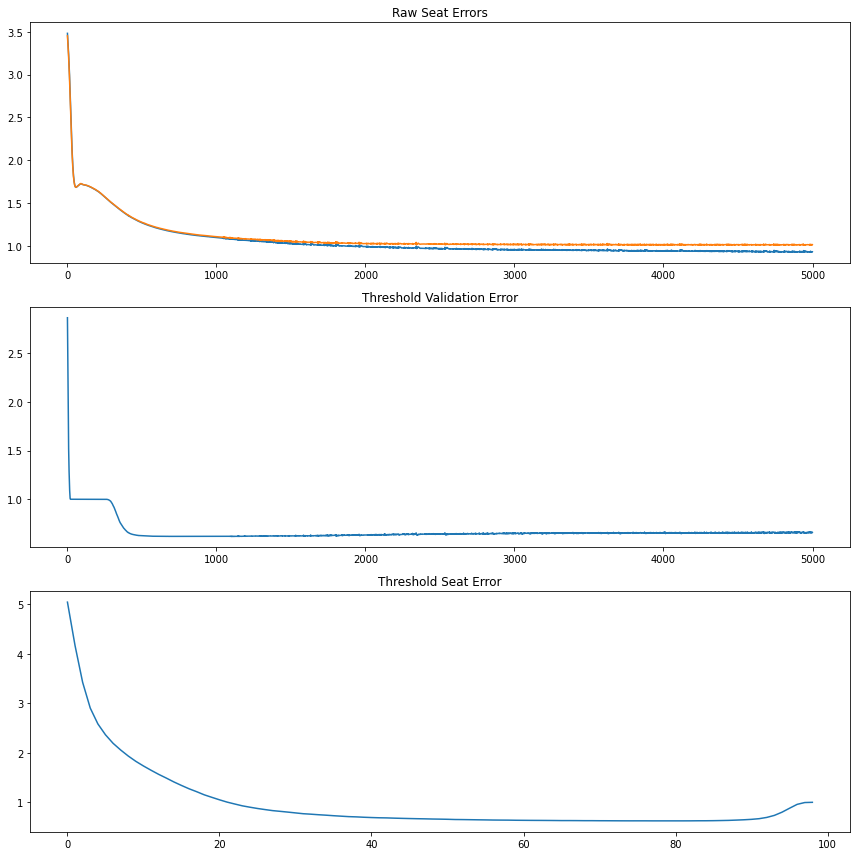

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import gc
import sys

# Prints the entire numpy array
np.set_printoptions(threshold=sys.maxsize)

# Deterministic randomness
torch.manual_seed(0)

# Garbage collect
gc.collect()

# Enables device agnostic tensor creation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Empty the CUDA cache
with torch.no_grad():
    torch.cuda.empty_cache()
torch.cuda.empty_cache()

# Recurrent Neural Network
class RNN(nn.Module):
    def __init__(self, n_inputs, n_neurons, X_in, seq_lengths):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(n_inputs, n_neurons, batch_first=True, num_layers=1, dropout=0.0)
        self.n_neurons = n_neurons
        self.X = X_in
        self.seq_lengths = seq_lengths
        self.FC = nn.Linear(self.n_neurons, 7)
    def forward(self):
        # Initialize the hidden state with all zeroes
        self.init_hidden()
        # Pack X
        self.X_packed = torch.nn.utils.rnn.pack_padded_sequence(Variable(self.X), self.seq_lengths, batch_first=True, enforce_sorted=False)
        # Calculate values of hidden states
        _, self.hx = self.rnn(self.X_packed)
        # Run the states through the sigmoid function
        sigmoid = nn.Sigmoid()
        out = sigmoid(self.FC(self.hx[0][0])).to(device)

        return out
    def init_hidden(self):
        self.hx = Variable(torch.zeros(1, len(self.X), self.n_neurons).to(device))

# Number of nodes in input layer
N_INPUT = 119

# Number of games
N_GAMES = 25000

# Training set
X, _, Y, train_game_numbers, train_seq_lengths, train_outed = populate_inputs(3, int(N_GAMES * 0.8), 30)

# Validation set
validation_X, _, validation_Y, validation_game_numbers, validation_seq_lengths, validation_outed = populate_inputs(int(N_GAMES * 0.8), int(N_GAMES * 1), 30)

# Testing set
test_X, _, test_Y, _, test_seq_lengths, _ = populate_inputs(int(N_GAMES * 0.8), N_GAMES - 1, 1)

# Convert to tensors
X = torch.as_tensor(X, dtype=torch.float32).to(device)
Y = torch.as_tensor(Y).to(device)
train_game_numbers = torch.as_tensor(train_game_numbers).to(device)
train_seq_lengths = torch.as_tensor(train_seq_lengths).to(device)
train_outed = torch.as_tensor(train_outed).to(device)

validation_X = torch.as_tensor(validation_X, dtype=torch.float32).to(device)
validation_Y = torch.as_tensor(validation_Y).to(device)
validation_game_numbers = torch.as_tensor(validation_game_numbers).to(device)
validation_seq_lengths = torch.as_tensor(validation_seq_lengths).to(device)
validation_outed = torch.as_tensor(validation_outed).to(device)

test_X = torch.as_tensor(test_X, dtype=torch.float32).to(device)
test_Y = torch.as_tensor(test_Y).to(device)
test_seq_lengths = torch.as_tensor(test_seq_lengths).to(device)

# Hyperparameters
N_EPOCHS = 5000
lr_array = [0.0015]
lambda_array = [.0004]
n_neurons_array = [22]

# Grid search
for LEARNING_RATE in lr_array:
    for LAMBDA_ in lambda_array:
        for N_NEURONS in n_neurons_array:
            # Saves and loads parameters depending on these values
            LOAD_PARAMS = False
            TESTING = False

            # Training model
            train_model = RNN(N_INPUT, N_NEURONS, X, train_seq_lengths).to(device)

            # Validation model
            validation_model = RNN(N_INPUT, N_NEURONS, validation_X, validation_seq_lengths).to(device)

            # Test model
            test_model = RNN(N_INPUT, N_NEURONS, test_X, test_seq_lengths).to(device)

            # Load parameters if requested
            if LOAD_PARAMS:
                train_model.load_state_dict(torch.load('parameters-saved'))

            # Set the loss function to binary cross entropy and use Adam optimizer
            criterion = nn.BCELoss().to(device)
            optimizer = optim.Adam(train_model.parameters(), lr=LEARNING_RATE, weight_decay=LAMBDA_)

            # Training metrics
            train_seat_errors = []

            # Validation metrics
            validation_seat_errors = []
            rounded_validation_seat_errors = []
            sorted_validation_seat_errors = []
            threshold_validation_seat_errors = []

            # Test set
            if TESTING:
                test_model.load_state_dict(torch.load('parameters-saved'))

                # Run testing metrics
                prediction = test_model()

                # Store the errors for the test set
                test_seat_error = torch.sum(torch.abs(test_Y - prediction)) / len(test_Y)

                # Store the errors for the test set, but round to either 0 or 1
                rounded_test_seat_error = torch.sum(torch.abs(test_Y - torch.round(prediction))) / len(test_Y)

                # Assume the 3 highest values are fascist and the rest are lib
                _, sorted_test_seat_indices = torch.sort(prediction)
                sorted_prediction = torch.zeros(prediction.size()).to(device)
                for i in range(5, 7):
                    for game in range(len(test_X)):
                        sorted_prediction[0][game][sorted_test_seat_indices[0][game][i]] = 1
                sorted_test_seat_error = torch.sum(torch.abs(test_Y - sorted_prediction)) / len(test_Y)

                # Data after all epochs
                print("Test error: " + str(test_seat_error))
                print("Test error with threshold: " + str(rounded_test_seat_error))
                print("Test error with sort: " + str(sorted_test_seat_error))

            # Training
            else:
                for epoch in range(N_EPOCHS):
                    # Print the epoch number every 100 epochs
                    if epoch % 100 == 0:
                        print("Epoch " + str(epoch))

                    train_model.train()
                    validation_model.train()

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # reset hidden states
                    train_model.init_hidden()
                    validation_model.init_hidden()

                    # Run the model, collect states (store them)
                    last_states = train_model()

                    # Calculate loss and backpropogate
                    loss = criterion(last_states.float(), Y.float())

                    loss.backward()
                    optimizer.step()

                    # Evaluate the training set errors and store them
                    train_seat_error = torch.sum(torch.abs(Y - last_states)) / len(Y)
                    train_seat_errors.append(train_seat_error.detach().item())
                    
                    train_model.eval()

                    # Transfer weights of training model to the validation model for validation
                    torch.save(train_model.state_dict(), 'parameters-transfer')
                    validation_model.load_state_dict(torch.load('parameters-transfer'))
                    
                    # Run the validation model on the validation data set and store predictions
                    prediction = validation_model()

                    # Store the errors for the validation set
                    validation_seat_error = torch.sum(torch.abs(validation_Y - prediction)) / len(validation_Y)
                    validation_seat_errors.append(validation_seat_error.detach().item())

                    # Store the errors for the validation set, but round to either 0 or 1
                    rounded_validation_seat_error = torch.sum(torch.abs(validation_Y - torch.round(prediction))) / len(validation_Y)
                    rounded_validation_seat_errors.append(rounded_validation_seat_error.detach().item())

                    # If this is the middle or last epoch
                    if (epoch + 1) % (N_EPOCHS / 2) == 0:

                        # Assume the 3 highest values are fascist and the rest are lib
                        _, sorted_validation_seat_indices = torch.sort(prediction)
                        sorted_prediction = torch.zeros(prediction.size()).to(device)
                        for game in range(len(validation_X)):
                            sorted_prediction[game][sorted_validation_seat_indices[game][6]] = 1
                        sorted_validation_seat_error = torch.sum(torch.abs(validation_Y - sorted_prediction)) / len(validation_Y)
                        sorted_validation_seat_errors.append(sorted_validation_seat_error.detach().item())

                    validation_model.eval()

            # Save the trained parameters
            if not TESTING:
                torch.save(train_model.state_dict(), 'parameters-saved')

            # Graph error vs threshold
            min_threshold_error = 10
            min_threshold_val = -1
            for threshold in range(49, -50, -1):
                threshold_seat_error = torch.sum(torch.abs(validation_Y - torch.round(prediction + .01 * threshold))) / len(validation_Y)
                cur_threshold_error = threshold_seat_error.detach().item()

                if cur_threshold_error < min_threshold_error:
                    min_threshold_error = cur_threshold_error
                    min_threshold_val = threshold

                threshold_validation_seat_errors.append(cur_threshold_error)

            # Print validation set results
            print("\nValidation Set Data")
            for game_index in range(len(validation_X) - 100, len(validation_X)):
                print("Game #" + str(validation_game_numbers[game_index]))
                print("Pred: " + str(prediction[game_index]) + "\nReal: " + str(validation_Y[game_index]))

            # Print hyperparameters
            print("\n" + '\033[1m' + "Hyperparameters")
            print('\033[21m' + "Number of Epochs:               " + str(N_EPOCHS))
            print("Learning rate:                  " + str(lr_array[0]))
            print("Lambda:                         " + str(lambda_array[0]))
            print("Number of Hidden Nodes:         " + str(n_neurons_array[0]))
            print("Number of Input Nodes:          " + str(N_INPUT))
            

            print(np.asarray(validation_X[-1].cpu()))

            print("\n" + '\033[1m' + "Custom Metrics")

            # Print the average conflict confidence on the training set
            sum = 0
            count = 0
            for game in range(len(train_outed)):
                for seat_number in range(7):
                    if train_outed[game][seat_number]:
                        count += 1
                        sum += last_states[game][seat_number]
            print('\033[21m' + "Training Conflict Confidence:   " + "%.4f" % (sum / count))

            # Print the average conflict confidence on the validation set
            sum = 0
            count = 0
            correct = 0
            for game in range(len(validation_outed)):
                for seat_number in range(7):
                    if validation_outed[game][seat_number]:
                        count += 1
                        correct += prediction[game][seat_number] > .5
                        sum += prediction[game][seat_number]
            print("Validation Conflict Confidence: " + "%.4f" % (sum / count))
            print("Validation Conflict Percent Correct: " + "%.4f" % (100 * correct / count))
            
            # Data after half of the epochs
            print("\n" + '\033[1m' + "Halfway")
            print('\033[21m' + "Train error: " + "                      %.4f" % train_seat_errors[int(-N_EPOCHS / 2)])
            print("Validation error: " + "                 %.4f" % validation_seat_errors[int(N_EPOCHS / 2)])
            print("Validation error with threshold: " + "  %.4f" % rounded_validation_seat_errors[int(N_EPOCHS / 2)])
            print("Validation error with sort: " + "       %.4f" % sorted_validation_seat_errors[-2])

            # Data after all epochs
            print("\n" + '\033[1m' + "End")
            print('\033[21m' + "Train error: " + "                      %.4f" % train_seat_errors[-1])
            print("Validation error: " + "                 %.4f" % validation_seat_errors[-1])
            print("Validation error with threshold: " + "  %.4f" % rounded_validation_seat_errors[-1])
            print("Validation error with sort: " + "       %.4f" % sorted_validation_seat_errors[-1])

            # Most optimal threshold data
            print("\nOptimal Threshold: " + "                %.4f" % (min_threshold_val * -.01 + .5))
            print("Optimal Threshold Error: " + "          %.4f" % min_threshold_error)

            # Write all of the above information for a single hyperparameter setup into a csv file
            file_hypers = open("Hyperparameter_Setups.csv", "a+")

            # Write the current results (for this hyperparameter setup)
            file_hypers.write("%.04f" % N_NEURONS + "," + "%.04f" % N_EPOCHS + "," + "%.04f" % LEARNING_RATE + "," + "%.04f" % LAMBDA_ + ",," + 
                              "%.04f" % train_seat_errors[int(-N_EPOCHS / 2)] + "," + "%.04f" % validation_seat_errors[int(N_EPOCHS / 2)] + "," + 
                                "%.04f" % rounded_validation_seat_errors[int(N_EPOCHS / 2)] + "," + "%.04f" % sorted_validation_seat_errors[-2] + ",," + 
                              "%.04f" % train_seat_errors[-1] + "," + "%.04f" % validation_seat_errors[-1] + "," + 
                                "%.04f" % rounded_validation_seat_errors[-1] + "," + "%.04f" % sorted_validation_seat_errors[-1] + "\n")
            file_hypers.close()

            plt.rcParams['figure.figsize'] = [12, 12]

            # Graph Train Error
            plt.subplot(3, 1, 1)
            plt.title("Raw Seat Errors")
            plt.plot(train_seat_errors)
            plt.plot(validation_seat_errors)

            # # Graph Validation Error
            # plt.subplot(3, 1, 2)
            # plt.title("Validation Error")
            # plt.plot(validation_seat_errors)

            # Graph validation set error
            plt.subplot(3, 1, 2)
            plt.title("Threshold Validation Error")
            plt.plot(rounded_validation_seat_errors)

            # Graph Validation Threshold Error
            plt.subplot(3, 1, 3)
            plt.title("Threshold Seat Error")
            plt.plot(threshold_validation_seat_errors)

            # Pad graphs so the titles and graphs don't overlap
            plt.tight_layout()

            # Show plot
            plt.show()
 

18
Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Epoch 1000
Epoch 1100
Epoch 1200
Epoch 1300
Epoch 1400
Epoch 1500
Epoch 1600
Epoch 1700
Epoch 1800
Epoch 1900
Epoch 2000
Epoch 2100
Epoch 2200
Epoch 2300
Epoch 2400
Epoch 2500
Epoch 2600
Epoch 2700
Epoch 2800
Epoch 2900
Epoch 3000
Epoch 3100
Epoch 3200
Epoch 3300
Epoch 3400
Epoch 3500
Epoch 3600
Epoch 3700
Epoch 3800
Epoch 3900
Epoch 4000
Epoch 4100
Epoch 4200
Epoch 4300
Epoch 4400
Epoch 4500
Epoch 4600
Epoch 4700
Epoch 4800
Epoch 4900

Validation Set Data
Game #tensor(24999, device='cuda:0')
Pred: tensor([0.3598, 0.2662, 0.7477, 0.6900, 0.2395, 0.3796, 0.0457],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([1, 0, 1, 0, 0, 1, 0], device='cuda:0')

End
Train error:                       2.1099
Validation error:                  2.1833
Validation error with threshold:   1.6889
Validation error with sort:        1.7526


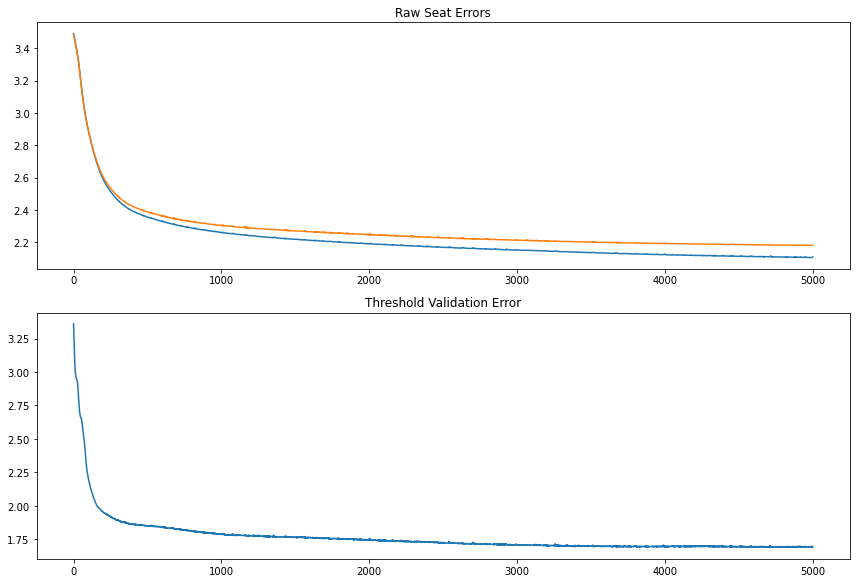

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import gc
import sys

# Prints the entire numpy array
np.set_printoptions(threshold=sys.maxsize)

# Deterministic randomness
torch.manual_seed(0)

# Garbage collect
gc.collect()

# Enables device agnostic tensor creation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Empty the CUDA cache
with torch.no_grad():
    torch.cuda.empty_cache()
torch.cuda.empty_cache()

# Recurrent Neural Network
class RNN(nn.Module):
    def __init__(self, n_inputs, n_neurons, X_in, seq_lengths):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(n_inputs, n_neurons, batch_first=True, num_layers=1, dropout=0.0)
        self.n_neurons = n_neurons
        self.X = X_in
        self.seq_lengths = seq_lengths
        self.FC = nn.Linear(self.n_neurons, 7)
    def forward(self):
        # Initialize the hidden state with all zeroes
        self.init_hidden()
        # Pack X
        self.X_packed = torch.nn.utils.rnn.pack_padded_sequence(Variable(self.X), self.seq_lengths, batch_first=True, enforce_sorted=False)
        # Calculate values of hidden states
        _, self.hx = self.rnn(self.X_packed)
        # Run the states through the sigmoid function
        sigmoid = nn.Sigmoid()
        out = sigmoid(self.FC(self.hx[0][0])).to(device)

        return out
    def init_hidden(self):
        self.hx = Variable(torch.zeros(1, len(self.X), self.n_neurons).to(device))

# Hyperparameters
N_EPOCHS = 5000
LEARNING_RATE = 0.0015
LAMBDA_ = .0004
N_NEURONS = 17

# Training lengths and file names
# training_lengths = [5, 10, 15, 20]
training_lengths = [20]
# Number of nodes in input layer
N_INPUT = 89

# Number of games
N_GAMES = 25000

for training_length in training_lengths:

    # Training set
    X, Y, _, train_game_numbers, train_seq_lengths, train_outed = populate_inputs(2, int(N_GAMES * 0.8), training_length)

    # Validation set
    validation_X, validation_Y, _, validation_game_numbers, validation_seq_lengths, validation_outed = populate_inputs(int(N_GAMES * 0.8), int(N_GAMES * 1), training_length)

    # Testing set
    test_X, test_Y, _, _, test_seq_lengths, _ = populate_inputs(int(N_GAMES * 0.8), N_GAMES - 1, 1)

    # Convert to tensors
    X = torch.as_tensor(X, dtype=torch.float32).to(device)
    Y = torch.as_tensor(Y).to(device)
    train_game_numbers = torch.as_tensor(train_game_numbers).to(device)
    train_seq_lengths = torch.as_tensor(train_seq_lengths).to(device)
    train_outed = torch.as_tensor(train_outed).to(device)

    validation_X = torch.as_tensor(validation_X, dtype=torch.float32).to(device)
    validation_Y = torch.as_tensor(validation_Y).to(device)
    validation_game_numbers = torch.as_tensor(validation_game_numbers).to(device)
    validation_seq_lengths = torch.as_tensor(validation_seq_lengths).to(device)
    validation_outed = torch.as_tensor(validation_outed).to(device)

    test_X = torch.as_tensor(test_X, dtype=torch.float32).to(device)
    test_Y = torch.as_tensor(test_Y).to(device)
    test_seq_lengths = torch.as_tensor(test_seq_lengths).to(device)

    # Training model
    train_model = RNN(N_INPUT, N_NEURONS, X, train_seq_lengths).to(device)

    # Validation model
    validation_model = RNN(N_INPUT, N_NEURONS, validation_X, validation_seq_lengths).to(device)

    # Test model
    test_model = RNN(N_INPUT, N_NEURONS, test_X, test_seq_lengths).to(device)

    # Set the loss function to binary cross entropy and use Adam optimizer
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(train_model.parameters(), lr=LEARNING_RATE, weight_decay=LAMBDA_)

    # Training metrics
    train_seat_errors = []

    # Validation metrics
    validation_seat_errors = []
    rounded_validation_seat_errors = []
    sorted_validation_seat_errors = []
    threshold_validation_seat_errors = []

    test_model.load_state_dict(torch.load('parameters-saved'))

    for epoch in range(N_EPOCHS):
        # Print the epoch number every 100 epochs
        if epoch % 100 == 0:
            print("Epoch " + str(epoch))

        train_model.train()
        validation_model.train()

        # zero the parameter gradients
        optimizer.zero_grad()

        # reset hidden states
        train_model.init_hidden()
        validation_model.init_hidden()

        # Run the model, collect states (store them)
        last_states = train_model()

        # Calculate loss and backpropogate
        loss = criterion(last_states.float(), Y.float())

        loss.backward()
        optimizer.step()

        # Evaluate the training set errors and store them
        train_seat_error = torch.sum(torch.abs(Y - last_states)) / len(Y)
        train_seat_errors.append(train_seat_error.detach().item())
        
        train_model.eval()

        # Transfer weights of training model to the validation model for validation
        torch.save(train_model.state_dict(), 'parameters-transfer')
        validation_model.load_state_dict(torch.load('parameters-transfer'))
        
        # Run the validation model on the validation data set and store predictions
        prediction = validation_model()

        # Store the errors for the validation set
        validation_seat_error = torch.sum(torch.abs(validation_Y - prediction)) / len(validation_Y)
        validation_seat_errors.append(validation_seat_error.detach().item())

        # Store the errors for the validation set, but round to either 0 or 1
        rounded_validation_seat_error = torch.sum(torch.abs(validation_Y - torch.round(prediction))) / len(validation_Y)
        rounded_validation_seat_errors.append(rounded_validation_seat_error.detach().item())

        # If this is the middle or last epoch
        if (epoch + 1) % (N_EPOCHS / 2) == 0:

            # Assume the 3 highest values are fascist and the rest are lib
            _, sorted_validation_seat_indices = torch.sort(prediction)
            sorted_prediction = torch.zeros(prediction.size()).to(device)
            for i in range(4, 7):
                for game in range(len(validation_X)):
                    sorted_prediction[game][sorted_validation_seat_indices[game][i]] = 1
            sorted_validation_seat_error = torch.sum(torch.abs(validation_Y - sorted_prediction)) / len(validation_Y)
            sorted_validation_seat_errors.append(sorted_validation_seat_error.detach().item())

        validation_model.eval()

    save_name = "parameters-" + str(training_length) + ".pt"
    torch.save(train_model.state_dict(), save_name)

    # Print validation set results
    print("\nValidation Set Data")
    print("Game #" + str(validation_game_numbers[-1]))
    print("Pred: " + str(prediction[-1]) + "\nReal: " + str(validation_Y[-1]))

    # Data after all epochs
    print("\n" + '\033[1m' + "End")
    print('\033[21m' + "Train error: " + "                      %.4f" % train_seat_errors[-1])
    print("Validation error: " + "                 %.4f" % validation_seat_errors[-1])
    print("Validation error with threshold: " + "  %.4f" % rounded_validation_seat_errors[-1])
    print("Validation error with sort: " + "       %.4f" % sorted_validation_seat_errors[-1])

    # Graph Train Error
    plt.subplot(3, 1, 1)
    plt.title("Raw Seat Errors")
    plt.plot(train_seat_errors)
    plt.plot(validation_seat_errors)

    # Graph validation set error
    plt.subplot(3, 1, 2)
    plt.title("Threshold Validation Error")
    plt.plot(rounded_validation_seat_errors)

    # Pad graphs so the titles and graphs don't overlap
    plt.tight_layout()

    # Show plot
    plt.show()

In [0]:
import json

def load_game(file_name):

    game_data = []
    game_outed = [0] * 7
    game_hitler = [0] * 7
    game_cnh = [0] * 7
    confirmed = [0] * 7

    lib_cards_played = 0
    fas_cards_played = 0

    with open(file_name) as file_in:
        data = json.load(file_in)

        # Encode network's seat
        for seat in range(0, 7):
            if data["players"][seat]["role"] == "liberal":
                confirmed[seat] = 1
                confirmed_seat = seat

        # Length 8 (1-7 - investigated seat number) (8 - result)
        investigation_data = [0] * 8
        # Length 7 (1-7 - chosen seat number)
        special_election_data = [0] * 7
        # Length 7 (1-7 - shot seat number)
        bullet_data_1 = [0] * 7
        # Length 7 (1-7 - shot seat number)
        bullet_data_2 = [0] * 7

        # For each government
        for gov in range(0, len(data["logs"])):

            # If a veto forces a td
            veto_and_td = False
            # Lenth 31 (1-7 - pres, 8-14 chanc, 15-18 pres claim, 19-21 chanc claim, 22 veto, 23 blue, 24 red, 25-31 vote data)
            gov_data = []
            topdeck = []

            # If the government was played
            if len(data["logs"][gov]) >= 5:

                # President seat number
                for pres in range(0, 7):
                    gov_data.append(1 if data["logs"][gov]["presidentId"] == pres else 0)

                # Chancellor seat number
                for chan in range(0, 7):
                    gov_data.append(1 if data["logs"][gov]["chancellorId"] == chan else 0)

                pres_claim = data["logs"][gov]["presidentClaim"]["reds"]
                chanc_claim = data["logs"][gov]["chancellorClaim"]["reds"]

                # President number of reds claimed
                if "presidentClaim" in data["logs"][gov]:
                    gov_data.append(1 if pres_claim == 0 else 0)
                    gov_data.append(1 if pres_claim == 1 else 0)
                    gov_data.append(1 if pres_claim == 2 else 0)
                    gov_data.append(1 if pres_claim == 3 else 0)

                # Chancellor number of reds claimed
                if "chancellorClaim" in data["logs"][gov]:
                    gov_data.append(1 if chanc_claim == 0 else 0)
                    gov_data.append(1 if chanc_claim == 1 else 0)
                    gov_data.append(1 if chanc_claim == 2 else 0)

                # Encode card outed
                if (confirmed_seat == data["logs"][gov]["presidentId"] or confirmed_seat == data["logs"][gov]["chancellorId"]) and (pres_claim - chanc_claim != 1 and pres_claim != 0) and "enactedPolicy" in data["logs"][gov] and data["logs"][gov]["enactedPolicy"] == "fascist":
                    game_outed[data["logs"][gov]["chancellorId" if confirmed_seat == data["logs"][gov]["presidentId"] else "presidentId"]] = 1
                    
                # Veto
                gov_data.append(1 if ("presidentVeto" in data["logs"][gov] and "chancellorVeto" in data["logs"][gov] and data["logs"][gov]["presidentVeto"] and data["logs"][gov]["chancellorVeto"]) else 0)

                # Enacted policy
                if "enactedPolicy" in data["logs"][gov]:
                    gov_data.append(0 if data["logs"][gov]["enactedPolicy"] == "fascist" else 1)
                    gov_data.append(1 if data["logs"][gov]["enactedPolicy"] == "fascist" else 0)
                else:
                    gov_data.append(0)
                    gov_data.append(0)

                # Vote data
                for seat in range(0, 7):
                    gov_data.append(1 if data["logs"][gov]["votes"][seat] else 0)
                
                # If investigation
                if "investigationId" in data["logs"][gov]:
                    investigation_data[data["logs"][gov]["investigationId"]] = 1
                    investigation_data[7] = 1 if data["logs"][gov]["investigationClaim"] == "fascist" else 0

                # Encode inv outed
                if "investigationId" in data["logs"][gov] and (confirmed_seat == data["logs"][gov]["presidentId"] or confirmed_seat == data["logs"][gov]["investigationId"]) and "investigationClaim" in data["logs"][gov] and data["logs"][gov]["investigationClaim"] == "fascist":
                    game_outed[data["logs"][gov]["investigationId" if confirmed_seat == data["logs"][gov]["presidentId"] else "presidentId"]] = 1

                # Encode inv confirmed
                if "investigationId" in data["logs"][gov] and confirmed_seat == data["logs"][gov]["presidentId"] and roles[data["logs"][gov]["investigationId"]] == 0:
                    confirmed[data["logs"][gov]["investigationId"]] = 1

                # Did a veto force a topdeck
                if "presidentVeto" in data["logs"][gov] and "chancellorVeto" in data["logs"][gov] and data["logs"][gov]["presidentVeto"] and data["logs"][gov]["chancellorVeto"] and "enactedPolicy" in data["logs"][gov]:
                    veto_and_td = True

                # If Special Election
                if "specialElection" in data["logs"][gov]:
                    special_election_data[data["logs"][gov]["specialElection"]] = 1

                # If bullet
                if "execution" in data["logs"][gov]:
                    # If first bullet
                    if not 1 in bullet_data_1:
                        bullet_data_1[data["logs"][gov]["execution"]] = 1
                    # If second bullet
                    else:
                        bullet_data_2[data["logs"][gov]["execution"]] = 1

            # Neined government
            else:
                # President seat number
                for pres in range(0, 7):
                    gov_data.append(1 if data["logs"][gov]["presidentId"] == pres else 0)

                # Chancellor seat number
                for chan in range(0, 7):
                    gov_data.append(1 if data["logs"][gov]["chancellorId"] == chan else 0)

                # Empty data
                for fill in range(8):
                    gov_data.append(0)

                # Encode enacted policy if topdecked
                if "enactedPolicy" in data["logs"][gov]:
                    gov_data.append(0 if data["logs"][gov]["enactedPolicy"] == "fascist" else 1)
                    gov_data.append(1 if data["logs"][gov]["enactedPolicy"] == "fascist" else 0)
                else:
                    gov_data.append(0)
                    gov_data.append(0)

                # Vote data
                for seat in range(0, 7):
                    gov_data.append(1 if data["logs"][gov]["votes"][seat] else 0)

            # If the government was a topdeck
            if (len(data["logs"][gov]) == 4 and ("enactedPolicy" in data["logs"][gov])) or veto_and_td:
                topdeck.append(1)
            else:
                topdeck.append(0)

            # If Hitler was elected in HZ
            if len(data["logs"][gov]) == 3 and gov == len(data["logs"]) - 1 and fas_cards_played >= 3:
                game_outed[data["logs"][gov]["chancellorId"]] = 1
                game_hitler[data["logs"][gov]["chancellorId"]] = 1

            # If Hitler was shot at any point
            if "execution" in data["logs"][gov] and gov == len(data["logs"]) - 1:
                game_outed[data["logs"][gov]["execution"]] = 1
                game_hitler[data["logs"][gov]["execution"]] = 1

            # Encode chancellors in HZ being CNH
            if len(data["logs"][gov]) >= 5 and fas_cards_played >= 3:
                game_cnh[data["logs"][gov]["chancellorId"]] = 1

            # All the people confirmed lib are also CNH, for example after inv
            for seat in range(7):
                game_cnh[seat] = game_cnh[seat] | confirmed[seat]

            if "enactedPolicy" in data["logs"][gov]:
                if data["logs"][gov]["enactedPolicy"] == "fascist":
                    fas_cards_played += 1
                else:
                    lib_cards_played += 1

            # Fill empty data with 0s
            for i in range(len(gov_data), 31):
                gov_data.append(0)

            game_data.append(gov_data + investigation_data + special_election_data + bullet_data_1 + bullet_data_2 + topdeck + confirmed + game_outed + game_hitler + game_cnh)

        model_game_length = ceil(len(game_data) / 5) * 5 if len(game_data) <= 20 else 30
        game_length = len(game_data)
        
        # Fill with 0s to fit the desired model length
        for i in range(len(game_data), model_game_length):
            game_data.append([0] * 89)

    return [game_data], game_length

In [0]:
import json
import re

def convert_to_json(file_name):

    data = {}
    data["logs"] = []

    with open(file_name) as file_in:
        lines = file_in.readlines()

    # Create players list that stores my_seat as liberal
    my_seat_index = int(re.split('SEAT', lines[0])[1]) - 1
    data["players"] = []
    for seat in range(7):
        seat_data = {}
        seat_data["role"] = "liberal" if seat == my_seat_index else "not_me"
        data["players"].append(seat_data)

    # Create government logs
    for line in lines[1:]:

        # Create dict to represent this government
        gov = {}
        # Votes list
        gov["votes"] = (list(re.split(' - ', line)[0]))
        # Convert to boolean
        for seat in range(7):
            gov["votes"][seat] = gov["votes"][seat] == "1"

        # President and chancellor Ids
        gov["presidentId"] = int(re.split(' - ', line)[1][0]) - 1
        gov["chancellorId"] = int(re.split(' - ', line)[1][1]) - 1

        # If the gov was played
        if len(line) > 15:

            # President claim
            reds = re.split(' - ', line)[1].split()[1].count('R')
            # Create dict
            gov["presidentClaim"] = {}
            # Number of reds and blues claimed
            gov["presidentClaim"]["reds"] = reds
            gov["presidentClaim"]["blues"] = 3 - reds

            # Chancellor claim
            reds = re.split(' - ', line)[1].split()[2].count('R')
            # Create dict
            gov["chancellorClaim"] = {}
            # Number of reds and blues claimed
            gov["chancellorClaim"]["reds"] = reds
            gov["chancellorClaim"]["blues"] = 2 - reds

            # Enacted policy
            policy = re.split(' - ', line)[1].split()[3]
            gov["enactedPolicy"] = "fascist" if policy == 'R' else "liberal"

            # If a special action (inv, se, bullet) was taken or veto took place
            if line.count('-') == 2:
                # If investigation
                if "INV" in line:
                    gov["investigationId"] = int(re.split(' - ', line)[2].split()[1]) - 1
                    gov["investigationClaim"] = "liberal" if re.split(' - ', line)[2].split()[2] == "LIB" else "fascist"
                
                # If special election
                if "SE" in line:
                    gov["specialElection"] = int(re.split(' - ', line)[2].split()[1]) - 1
                
                # If bullet
                if "KILL" in line:
                    gov["execution"] = int(re.split(' - ', line)[2].split()[1]) - 1

                if "VETO" in line:
                    gov["presidentVeto"] = True
                    gov["chancellorVeto"] = True
        
        # Check if this gov was a topdeck
        elif len(line) == 15:
            policy = re.split(' - ', line)[1].split()[1]
            gov["enactedPolicy"] = "fascist" if policy == 'R' else "liberal"

        # Append this gov to the data
        data["logs"].append(gov)

    new_file_name = "game_out.json"
    with open(new_file_name, 'w') as file_out:
        json.dump(data, file_out)

    return new_file_name

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
from torch.autograd import Variable
from math import ceil
import matplotlib.pyplot as plt
import gc
import sys

# Prints the entire numpy array
np.set_printoptions(threshold=sys.maxsize)

# Deterministic randomness
torch.manual_seed(0)

# Garbage collect
gc.collect()

# Enables device agnostic tensor creation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Empty the CUDA cache
with torch.no_grad():
    torch.cuda.empty_cache()
torch.cuda.empty_cache()

# Recurrent Neural Network
class RNN(nn.Module):
    def __init__(self, n_inputs, n_neurons, X_in, seq_lengths):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(n_inputs, n_neurons, batch_first=True, num_layers=1, dropout=0.0)
        self.n_neurons = n_neurons
        self.X = X_in
        self.seq_lengths = seq_lengths
        self.FC = nn.Linear(self.n_neurons, 7)
    def forward(self):
        # Initialize the hidden state with all zeroes
        self.init_hidden()
        # Pack X
        self.X_packed = torch.nn.utils.rnn.pack_padded_sequence(Variable(self.X), self.seq_lengths, batch_first=True, enforce_sorted=False)
        # Calculate values of hidden states
        _, self.hx = self.rnn(self.X_packed)
        # Run the states through the sigmoid function
        sigmoid = nn.Sigmoid()
        out = sigmoid(self.FC(self.hx[0][0])).to(device)

        return out
    def init_hidden(self):
        self.hx = Variable(torch.zeros(1, len(self.X), self.n_neurons).to(device))

# Size of input layer
N_INPUT = 89
# Size of hidden layer
N_NEURONS = 17

# Name of game file
file_name = "game_in.txt"

# Training set
X, game_length = load_game(convert_to_json(file_name))

# Convert to tensor
X = torch.as_tensor(X, dtype=torch.float32).to(device)

# Determine appropriate model based on game length
model_game_length = ceil(len(X[0]) / 5) * 5 if len(X[0]) <= 20 else 30

# Create model
model = RNN(N_INPUT, N_NEURONS, X, [game_length]).to(device)

# Load the correct model parameters
parameter_file_name = "parameters-" + str(model_game_length) + ".pt"
model.load_state_dict(torch.load(parameter_file_name))

# Get prediction
prediction = model()

print(prediction)

tensor([[0.3598, 0.2662, 0.7477, 0.6900, 0.2395, 0.3796, 0.0457]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
